# Librerías:

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import calendar

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Lectura de datos:
Se carga el dataset original y modificado para comparar los datos.

In [40]:
original_bike_sharing_df = pd.read_csv('../data/bike_sharing_original.csv')
bike_sharing_df = pd.read_csv('../data/bike_sharing_modified.csv')

In [41]:
target_rows_to_drop = bike_sharing_df.shape[0] - original_bike_sharing_df.shape[0]
target_cols_to_drop = bike_sharing_df.shape[1] - original_bike_sharing_df.shape[1]

print(f'Registros objetivo a eliminar {target_rows_to_drop}')
print(f'Columnas objetivo a eliminar {target_cols_to_drop}')

Registros objetivo a eliminar 347
Columnas objetivo a eliminar 1


# Exploratory Data Analysis (EDA):
- Identificar tipos de datos
- Funciones base de manipulación de datos (eliminar variables, castear valores, etc.)
- Estadísticas descriptivas de los datos
- Identificar valores atípicos & faltantes
- Gráficas para visualizar la distribución por variable

In [42]:
def get_df_info(df):
    df.info()

In [43]:
def get_EDA(df):
    print(df.describe().T)

In [44]:
def get_outliers(df, col):
    percentile_25 = df[col].quantile(0.25)
    percentile_75 = df[col].quantile(0.75)
    iqr = percentile_75 - percentile_25
    upper_limit = percentile_75 + 1.5 * iqr
    lower_limit = percentile_25 - 1.5 * iqr
    IQR_outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    
    return IQR_outliers

In [45]:
def get_NaN_values(df):
    print(f'Valores NaN:\n')
    print(df.isna().sum())

In [46]:
def get_missing_values_by_col(df, col):
    missing_values_mask = df[col].isna()
    
    df_missing_values = df[missing_values_mask].copy()

    return df_missing_values

In [47]:
def get_cat_cols(df):
    cat_cols = df.select_dtypes(include = 'object').columns.tolist()

    return cat_cols

In [48]:
def get_num_cols(df):
    num_cols = df.select_dtypes(exclude = 'object').columns.tolist()

    return num_cols

In [49]:
def get_distribution_summary(df, num_cols):
    summary_data = []
    
    for col in num_cols:
        skew = df[col].skew()
        
        if skew > 0.5:
            skew_interpret = 'Sesgo Derecho (Positivo)'
        elif skew < -0.5:
            skew_interpret = 'Sesgo Izquierdo (Negativo)'
        else:
            skew_interpret = 'Simétrico/Ligero'
        
        
        kurtosis = df[col].kurtosis()

        if kurtosis > 0.5:
            kurtosis_interpret = 'Leptocúrtica (Colas Pesadas)'
        elif kurtosis < -0.5:
            kurtosis_interpret = 'Platicúrtica (Colas Ligeras)'
        else:
            kurtosis_interpret = 'Mesocúrtica (Normal)'

        summary_data.append({
            'Variable': col,
            'Skewness': skew,
            'Kurtosis': kurtosis,
            'Tipo de Sesgo': skew_interpret,
            'Forma de la Distribucion': kurtosis_interpret
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df[['Skewness', 'Kurtosis']] = summary_df[['Skewness', 'Kurtosis']].round(2)
    
    return summary_df

In [50]:
def create_barplots(df, cat_cols, n_rows, n_cols):
    """
    Genera gráficas de barras para variables categóricas.
    
    Args:
        df: dataframe de entrada
        cat_cols: lista de nombres de columnas categóricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.6)

    fig.suptitle('Gráficas de Barras: Variables Categóricas', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(cat_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.countplot(x=df[col], ax=ax, palette='rocket', legend=False)
        ax.set_title(f'Conteo: {col}', fontsize=12)
        ax.set_xlabel(None)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=90) 

    # ocultar espacios innecesarios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [51]:
def create_histograms(df, num_cols, n_rows, n_cols):
    """
    Generar histogramas + KDE para variables numéricas
    
    Params:
        df: dataframe de entrada
        num_cols: lista de columnas numéricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    fig.suptitle('Histogramas: Variables Numéricas', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(num_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.histplot(x=df[col], ax=ax, kde=True, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribución de: {col}', fontsize=12)
        ax.set_xlabel(None)
        ax.set_ylabel('Frecuencia/Densidad')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [52]:
def create_boxplots(df, num_cols, n_rows, n_cols):
    """
    Generar Box Plots para variables numéricas & detectar outliers (IQR)
    
    Args:
        df: dataframe de entrada
        num_cols: lista de nombres de columnas numéricas
        n_rows: # de filas en el grid de subplots
        n_cols: # de columnas en el grid de subplots
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    fig.suptitle('Box Plots / Detección de Outliers (IQR)', fontsize=12)

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(num_cols):
        if i >= len(axes):
            break
        
        ax = axes[i]
        sns.boxplot(x=df[col], ax=ax, showmeans=True)
        ax.set_title(f'Box Plot: {col}', fontsize=12)
        ax.set_xlabel(f'{col}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [53]:
def create_correlation_heatmap(df, num_cols):
    """
    Generar Heatmap para visualizar la matriz de correlación 
    entre las variables numéricas.

    Args:
        df: dataframe de entrada
        num_cols: lista de nombres de columnas numéricas
        figsize: tupla para el tamaño de la figura (width, height)
    """    
    corr_matrix = df[num_cols].corr()

    plt.figure(figsize=(12, 8))
    
    sns.heatmap(
        corr_matrix, 
        annot=True,              
        fmt=".2f",               
        cmap='rocket',         
        linewidths=.5,           
        linecolor='black',       
        cbar_kws={'label': 'Coeficiente de Correlación'}
    )
    
    plt.title('Mapa de Calor de Correlación (Variables Numéricas)', fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() 

    plt.show()

In [54]:
def drop_cols(df, cols):
    df.drop(columns = cols, inplace=True)
    print(f'Columna (s) {cols} eliminada (s) del dataframe.')

In [55]:
def get_cols_to_drop(baseline_df, modified_df):
    original_cols = set(baseline_df.columns)
    modified_cols = set(modified_df.columns)

    cols_to_drop = []
    diff_cols = modified_cols - original_cols

    if len(diff_cols) == target_cols_to_drop:
        cols_to_drop = diff_cols.pop()
        print(f'Columna (s) a eliminar: {cols_to_drop}')

    return cols_to_drop

In [56]:
def cast_values(df):
        column_types_map = {
            'instant': 'int',
            'season': 'int',
            'yr': 'int',
            'mnth': 'int',
            'hr': 'int',
            'holiday': 'int',
            'weekday': 'int',
            'workingday': 'int',
            'weathersit': 'int',
            'temp': 'float',
            'atemp': 'float',
            'hum': 'float',
            'windspeed': 'float',
            'casual': 'int',
            'registered': 'int',
            'cnt': 'int',
            'mixed_type_col': 'int'
        }

        cast_map = {
            'int': lambda df, col: pd.to_numeric(df[col], errors='coerce').astype('Int64'),
            'float': lambda df, col: pd.to_numeric(df[col], errors='coerce').astype('float64')
        }
        
        for col_name, target_dtype in column_types_map.items():
            if col_name in df.columns:
                cast_map.get(target_dtype.lower())

                cast_action = cast_map.get(target_dtype.lower())

                if cast_action:
                    df[col_name] = cast_action(df, col_name)


In [57]:
get_df_info(bike_sharing_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17726 entries, 0 to 17725
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   instant         17524 non-null  object
 1   dteday          17542 non-null  object
 2   season          17519 non-null  object
 3   yr              17515 non-null  object
 4   mnth            17515 non-null  object
 5   hr              17489 non-null  object
 6   holiday         17552 non-null  object
 7   weekday         17539 non-null  object
 8   workingday      17527 non-null  object
 9   weathersit      17526 non-null  object
 10  temp            17546 non-null  object
 11  atemp           17534 non-null  object
 12  hum             17512 non-null  object
 13  windspeed       17545 non-null  object
 14  casual          17523 non-null  object
 15  registered      17530 non-null  object
 16  cnt             17534 non-null  object
 17  mixed_type_col  15973 non-null  object
dtypes: obj

In [58]:
get_EDA(bike_sharing_df)

                count unique         top   freq
instant         17524  17085       error     23
dteday          17542   1253  2012-03-30     26
season          17519    155         3.0   4243
yr              17515    128         1.0   8224
mnth            17515    190         7.0   1422
hr              17489    218        20.0    701
holiday         17552    101         0.0  16048
weekday         17539    168         6.0   2386
workingday      17527    119         1.0  11225
weathersit      17526    172         1.0  10809
temp            17546    281        0.62    689
atemp           17534    320      0.6212    925
hum             17512    337        0.88    627
windspeed       17545    219         0.0   2076
casual          17523    598         0.0   1493
registered      17530   1227         4.0    294
cnt             17534   1372         5.0    237
mixed_type_col  15973   1002     unknown   1768


In [59]:
cast_values(bike_sharing_df)

In [60]:
get_NaN_values(bike_sharing_df)

Valores NaN:

instant            273
dteday             184
season             264
yr                 274
mnth               282
hr                 293
holiday            249
weekday            246
workingday         262
weathersit         266
temp               236
atemp              252
hum                277
windspeed          247
casual             272
registered         256
cnt                247
mixed_type_col    5265
dtype: int64


In [61]:
cols_to_drop = get_cols_to_drop(original_bike_sharing_df, bike_sharing_df)
drop_cols(bike_sharing_df, cols_to_drop)

Columna (s) a eliminar: mixed_type_col
Columna (s) mixed_type_col eliminada (s) del dataframe.


In [62]:
cat_cols = get_cat_cols(bike_sharing_df)
num_cols = get_num_cols(bike_sharing_df)

In [63]:
print(f'\nAnálisis del sesgo de la distribución (skew) & la forma de la distribución (kurtosis):')
distribution_summary_df = get_distribution_summary(bike_sharing_df, num_cols)
distribution_summary_df


Análisis del sesgo de la distribución (skew) & la forma de la distribución (kurtosis):


,Variable,Skewness,Kurtosis,Tipo de Sesgo,Forma de la Distribucion
0,instant,22.90,587.27,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
1,season,17.54,336.03,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
2,yr,19.17,398.62,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
3,mnth,13.57,198.61,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
4,hr,15.30,285.69,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
5,holiday,16.79,299.50,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
6,weekday,91.78,10490.08,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
7,workingday,18.35,356.24,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
8,weathersit,15.71,262.96,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
9,temp,16.71,293.49,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)


In [64]:
print(f'\nAnálisis de Valores Atípicos:')

for col in num_cols:
    outliers_df = get_outliers(bike_sharing_df, col)
    
    if len(outliers_df) > 0:
        print(f'\n[{col}]\n')
        print(outliers_df) 
    else:
        print(f'\nNo se encontraron resultados para [{col}]')
    
    print('_' * 40)


Análisis de Valores Atípicos:

[instant]

       instant        dteday  season  yr  mnth  hr  holiday  weekday  \
535      48240    2011-01-24       1   0     1  11        0        1   
642      36008    2011-01-30       1   0     1   1        0        0   
653      33354   2011-01-30        1   0     1  13        0        0   
654      63535    2011-01-30       1   0     1  14        0        0   
1035     66304    2011-02-15       1   0     2  20        0        2   
...        ...           ...     ...  ..   ...  ..      ...      ...   
16360  1177992    2012-11-19       4   1    11  10        0        1   
16399   869200    2012-11-21       4   1    11   1        0        3   
17493  1309860    2012-12-25       1   1    12  23        1        2   
17542   938174    2012-04-04       2   1     4  16        0        3   
17684   190355    2012-12-28       1   1    12  21        0        5   

       workingday  weathersit  temp   atemp    hum  windspeed  casual  \
535             1  

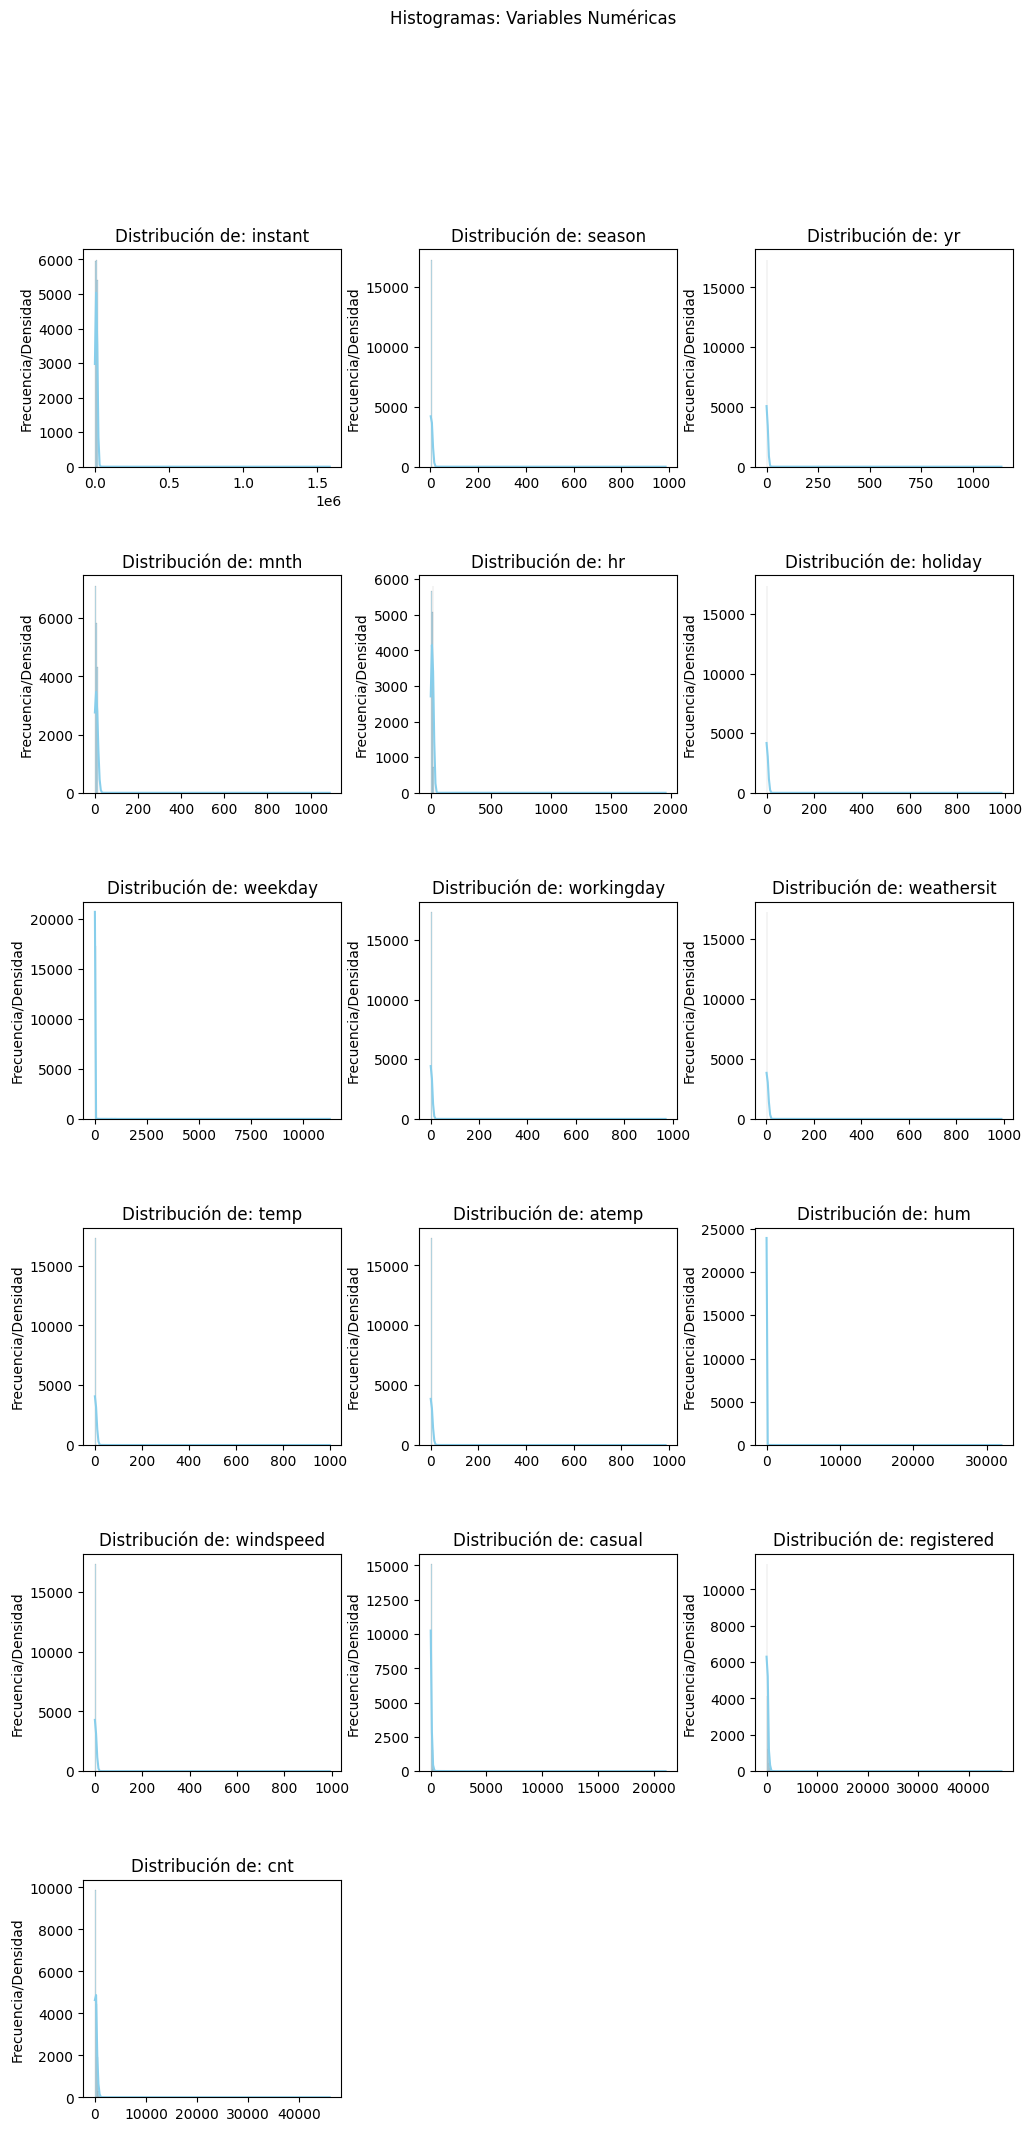

In [65]:
create_histograms(bike_sharing_df, num_cols, 6, 3)

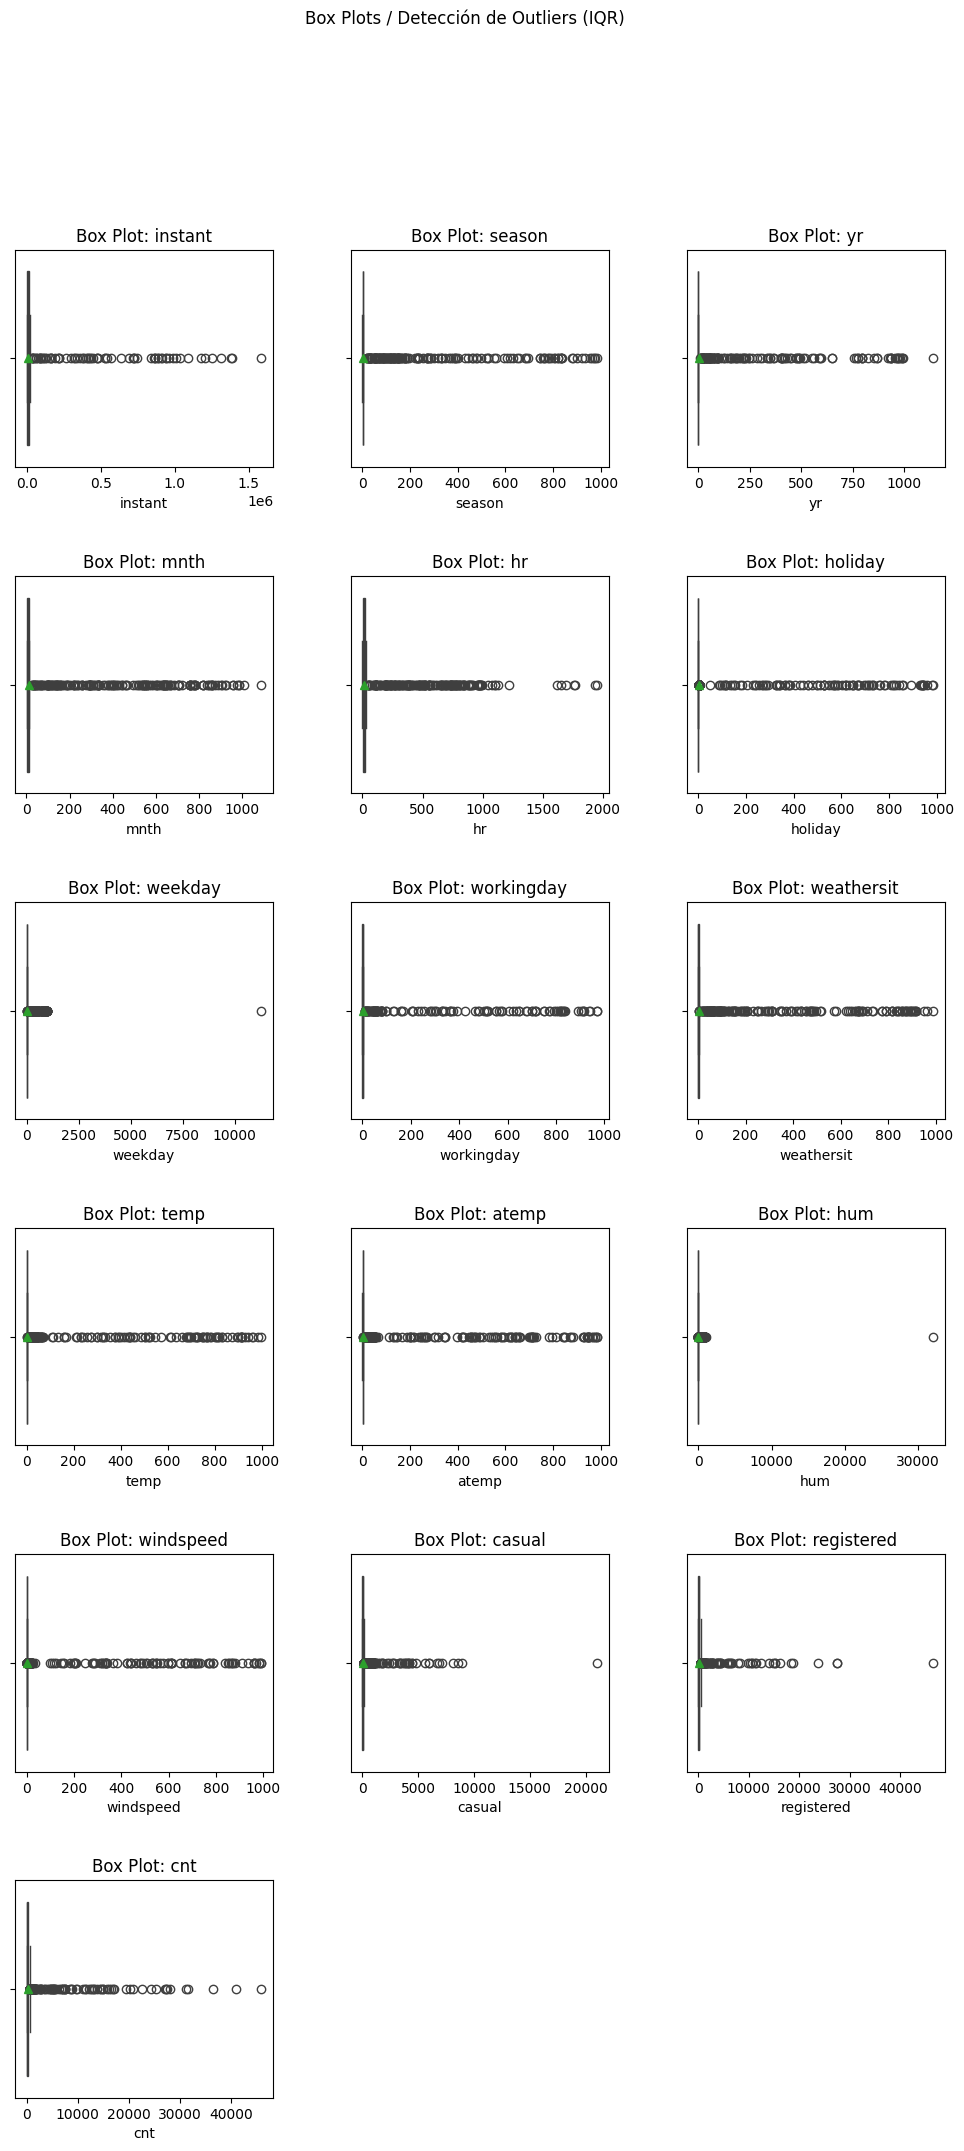

In [66]:
create_boxplots(bike_sharing_df, num_cols, 6, 3)

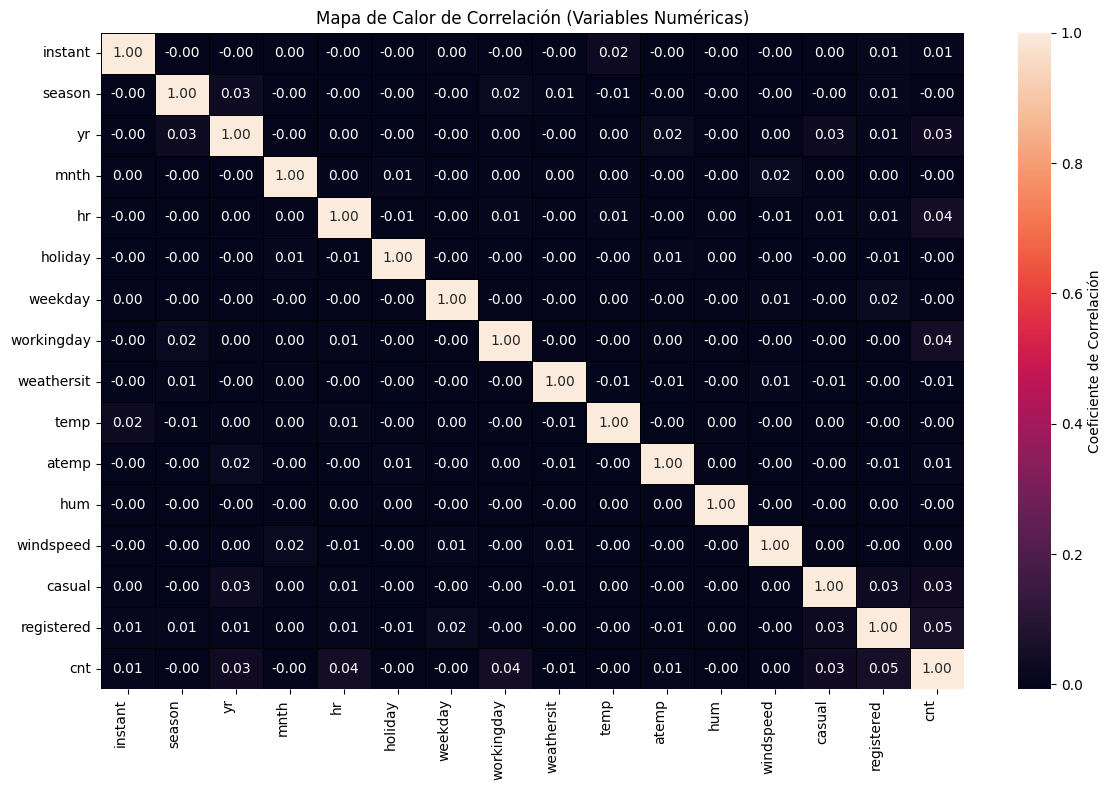

In [67]:
create_correlation_heatmap(bike_sharing_df, num_cols)

# Limpieza de datos:
- Manejo de valores faltantes en todas las variables
- Manejo de valores atípicos en todas las variables
- Estandarización de formato de fechas
- Estandarización de parámetros (ej: formato 24 hrs para variable 'hr')
- Manejo de operaciones aritméticas correctas ('casual' + 'registered' = 'cnt')

In [68]:
## DATEDAY -> formato de fecha
##
def convert_date_format(df, date_col):
    count = 0

    df[date_col] = df[date_col].astype(str).str.strip()
    initial_series = df[date_col].copy()

    # Formato 1: YYYY-MM-DD
    df[date_col] = pd.to_datetime(initial_series, format='%Y-%m-%d', errors='coerce')
    
    # Formato 2: MM/DD/YYYY (US)
    mask_nan_us = df[date_col].isna()
    
    df.loc[mask_nan_us, date_col] = pd.to_datetime(
        initial_series[mask_nan_us], 
        format='%m/%d/%Y', 
        errors='coerce'
    )

    count += (~df[date_col].isna() | mask_nan_us).sum()

    # Formato 3: DD/MM/YYYY (EU)
    mask_nan_eu = df[date_col].isna()

    df.loc[mask_nan_eu, date_col] = pd.to_datetime(
        initial_series[mask_nan_eu], 
        format='%d/%m/%Y', 
        errors='coerce'
    )

    count += (~df[date_col].isna() | mask_nan_eu).sum()

    print(f'Datos manipulados: {count}')
    
    return df


bike_sharing_df = convert_date_format(bike_sharing_df, 'dteday')

Datos manipulados: 35452


In [69]:
## HOUR
##
def clean_hour(df, hour_col, date_col):
    CUTOFF_DATE = pd.to_datetime('2012-12-31')
    CUTOFF_HR = 23.0 

    count = 0

    df[hour_col] = pd.to_numeric(df[hour_col], errors='coerce') # cast string a numérica para convertir valores corruptos a NaN
    df[hour_col].fillna(-1.0, inplace=True)
    df[hour_col] = df[hour_col].astype(float)

    for i in range(1, len(df)):
        
        current_date = df.loc[i, date_col]
        current_hr = df.loc[i, hour_col]
        
        prev_date = df.loc[i - 1, date_col]
        prev_hr = df.loc[i - 1, hour_col]
        
        if prev_date == CUTOFF_DATE and prev_hr == CUTOFF_HR: # poka-yoke en la última hora del último día de 2012
            break
            
        expected_hr = (prev_hr + 1) % 24 # formato 24 horas
        
        out_of_range_flag = (current_hr < 0) or (current_hr > 23)
        
        if out_of_range_flag:
            # Caso 1: si el valor es 1) corrupto o 2) fuera del rango de 24 hr, imputamos el valor secuencial esperado
            df.loc[i, hour_col] = expected_hr

            count += 1

            if expected_hr == 0:
                if pd.notna(prev_date):
                    df.loc[i, date_col] = prev_date + pd.Timedelta(days=1)
                                    
        elif current_hr != expected_hr:
            # Caso 2: si es un salto en la secuencia numérica (ej. 1 -> 4) y NO es un cambio de día, no se realiza imputación
            pass

        df[hour_col] = df[hour_col].astype(int)

        mask_final_outlier = (df[hour_col] < 0) | (df[hour_col] > 23)

        if mask_final_outlier.sum() > 0:
            indices_to_fix = df[mask_final_outlier].index
            
            for idx in indices_to_fix:
                if idx > 0:
                    prev_hr_fixed = df.loc[idx - 1, hour_col]
                    prev_date_fixed = df.loc[idx - 1, date_col]
                    
                    expected_hr_current = (prev_hr_fixed + 1) % 24
                    
                    df.loc[idx, hour_col] = expected_hr_current
                    
                    count += 1

                    if expected_hr_current == 0: # corregir dteday si hay salto de día
                        if pd.notna(prev_date_fixed):
                            df.loc[idx, date_col] = prev_date_fixed + pd.Timedelta(days=1)
                else:
                   df.loc[idx, hour_col] = 0.0
                    
        print(f'Datos manipulados: {count}')

        df[hour_col] = df[hour_col].astype(int)

        return df


bike_sharing_df = clean_hour(bike_sharing_df, 'hr', 'dteday')

Datos manipulados: 467


C:\Users\landy\AppData\Local\Temp\ipykernel_20364\546339897.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[hour_col].fillna(-1.0, inplace=True)


In [70]:
## DATE DAY
#
def impute_date(df, date_col, hour_col):
    count = 0

    mask_to_impute = df[date_col].isna() & \
                     df[hour_col].notna()

    indixes_to_impute = df[mask_to_impute].index
    
    for idx in indixes_to_impute:
        if idx > 0:
            
            current_hr = df.loc[idx, hour_col]
            prev_idx = idx - 1
            prev_dteday = df.loc[prev_idx, date_col]
            prev_hr = df.loc[prev_idx, hour_col]
            
            if pd.isna(prev_dteday):
                continue # si no hay fecha anterior, se omite
            
            sequential_jump_flag = (current_hr == (prev_hr + 1)) or (prev_hr == 23 and current_hr == 0)
            
            if sequential_jump_flag:
                
                if current_hr == 0:
                    new_date = prev_dteday + pd.Timedelta(days=1)
                
                else:
                    new_date = prev_dteday
                
                df.loc[idx, date_col] = new_date
                count += 1

    print(f'Datos manipulados: {count}')
    
    return df


bike_sharing_df = impute_date(bike_sharing_df, 'dteday', 'hr')

Datos manipulados: 191


In [71]:
## YEAR
##
def clean_year(df, year_col, date_col):
    YEAR_MAPPING = {2011: 0.0, 2012: 1.0}

    count = 0

    count_before_fillna = df[year_col].isna().sum()
    df[year_col].fillna(df[date_col].dt.year.map(YEAR_MAPPING), inplace=True)
    count += count_before_fillna - df[year_col].isna().sum()

    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')

    mask_corrupt_year = (df[year_col].isna()) | \
                    (~df[year_col].isin([0.0, 1.0])) # rango [0,1] para años (2011, 2012)
    count += mask_corrupt_year.sum() 

    imputed_yr_values = df.loc[mask_corrupt_year, date_col].dt.year.map(YEAR_MAPPING)

    df.loc[mask_corrupt_year, year_col] = imputed_yr_values

    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_year(bike_sharing_df, 'yr', 'dteday')

Datos manipulados: 410


C:\Users\landy\AppData\Local\Temp\ipykernel_20364\1651103133.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[year_col].fillna(df[date_col].dt.year.map(YEAR_MAPPING), inplace=True)


In [72]:
## MONTH
##
def clean_month(df, month_col, date_col):
    count = 0

    count_before_fillna = df[month_col].isna().sum() 
    df[month_col].fillna(df[date_col].dt.month, inplace=True)
    count += count_before_fillna - df[month_col].isna().sum()
    
    df[month_col] = pd.to_numeric(df[month_col], errors='coerce')

    mask_corrupt_month = (df[month_col].isna()) | \
                        (df[month_col] < 1) | \
                        (df[month_col] > 12) # rango [1-12] para meses
    count += mask_corrupt_month.sum()

    df.loc[mask_corrupt_month, month_col] = df.loc[mask_corrupt_month, date_col].dt.month.astype(float)

    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_month(bike_sharing_df, 'mnth', 'dteday')

Datos manipulados: 459


C:\Users\landy\AppData\Local\Temp\ipykernel_20364\1326134060.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[month_col].fillna(df[date_col].dt.month, inplace=True)


In [73]:
## WEEKDAY
##
def clean_weekday(df, weekday_col, date_col):
    count = 0

    count_before_fillna = df[weekday_col].isna().sum()
    df[weekday_col].fillna(df[date_col].dt.weekday, inplace=True)
    count += count_before_fillna - df[weekday_col].isna().sum()

    df[weekday_col] = pd.to_numeric(df[weekday_col], errors='coerce')

    mask_corrupt_weekday = (bike_sharing_df[weekday_col].isna()) | \
                        (bike_sharing_df[weekday_col] < 0) | \
                        (bike_sharing_df[weekday_col] > 6) # rango [0-6] para días de la semana
    count += mask_corrupt_weekday.sum()

    imputed_weekday_values = bike_sharing_df.loc[mask_corrupt_weekday, date_col].dt.weekday.astype(float)

    bike_sharing_df.loc[mask_corrupt_weekday, weekday_col] = imputed_weekday_values

    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_weekday(bike_sharing_df, 'weekday', 'dteday')


Datos manipulados: 404


C:\Users\landy\AppData\Local\Temp\ipykernel_20364\1909220552.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[weekday_col].fillna(df[date_col].dt.weekday, inplace=True)


In [74]:
## HOLIDAY
#
def clean_holiday(df, holiday_col, date_col):
    count = 0

    us_holidays = holidays.US(years=[2011, 2012])

    def get_us_holiday(date):
        if pd.isna(date):
            return np.nan
        
        return 1.0 if date in us_holidays else 0.0


    df[holiday_col] = pd.to_numeric(df[holiday_col], errors='coerce')

    mask_corrupt_holiday = (df[holiday_col].isna()) | \
                        (~df[holiday_col].isin([0.0, 1.0]))
    count += mask_corrupt_holiday.sum()

    imputed_holiday_values = df.loc[mask_corrupt_holiday, date_col].apply(get_us_holiday)

    df.loc[mask_corrupt_holiday, holiday_col] = imputed_holiday_values
    df[holiday_col].astype(int)
    
    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_holiday(bike_sharing_df, 'holiday', 'dteday')

Datos manipulados: 345


In [75]:
## WORKING DAY
#
def clean_workday(df, workday_col, weekday_col, holiday_col):
    count = 0
    
    df[workday_col] = pd.to_numeric(df[workday_col], errors='coerce')

    mask_corrupt_workingday = (df[workday_col].isna()) | \
                            (~df[workday_col].isin([0.0, 1.0]))
    count += mask_corrupt_workingday.sum()

    imputed_workingday_values = df.loc[mask_corrupt_workingday, weekday_col].apply(
        lambda x: 0.0 if x in [0.0, 6.0] else 1.0
    ) # si 'weekday' está en [0, 6], 'workingday' debe ser 0, sino debe ser 1

    df.loc[mask_corrupt_workingday, workday_col] = imputed_workingday_values
    count += (df.loc[df[holiday_col] == 1.0, workday_col] != 0.0).sum()

    df.loc[df[holiday_col] == 1.0, workday_col] = 0.0 # si es día festivo (holiday=1), NO puede ser día laboral (workingday=0)

    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_workday(bike_sharing_df, 'workingday', 'weekday', 'holiday')

Datos manipulados: 388


In [76]:
## SEASON
#
def map_season(current_date):
    
    if pd.isna(current_date):
        return np.nan
    
    month_day = (current_date.month, current_date.day)

    # 1.0 == invierno: 21-Dic al 20-Mar
    if (month_day >= (12, 21)) or (month_day <= (3, 20)):
        return 1.0 
    
    # 2.0 == primavera: 21-Mar al 20-Jun
    elif (month_day >= (3, 21)) and (month_day <= (6, 20)):
        return 2.0
        
    # 3.0 == verano: 21-Jun al 22-Sep
    elif (month_day >= (6, 21)) and (month_day <= (9, 22)):
        return 3.0
        
    # 4.0 == otoño): 23-Sep al 20-Dic
    elif (month_day >= (9, 23)) and (month_day <= (12, 20)):
        return 4.0
        
    return np.nan

def clean_season(df, season_col, date_col):
    count = 0

    df[season_col] = pd.to_numeric(df[season_col], errors='coerce')

    mask_corrupt_season = (df[season_col].isna()) | \
                        (df[season_col] < 1.0) | \
                        (df[season_col] > 4.0) | \
                        (df[season_col] % 1 != 0)
    count += mask_corrupt_season.sum()

    imputed_season_values = df.loc[mask_corrupt_season, date_col].apply(map_season)

    df.loc[mask_corrupt_season, season_col] = imputed_season_values

    print(f'Datos manipulados: {count}')

    return df


bike_sharing_df = clean_season(bike_sharing_df, 'season', 'dteday')

Datos manipulados: 432


In [77]:
## INSTANT
#
def impute_instant(df, instant_col, date_col, hour_col):
    count = 0

    mask_instant_nan = df[instant_col].isna()
    indexes_to_impute = df[mask_instant_nan].index
    
    for idx in indexes_to_impute:
        
        if idx > 0 and idx < len(df) - 1:
            
            prev_idx = idx - 1
            prev_instant = df.loc[prev_idx, instant_col]
            prev_date = df.loc[prev_idx, date_col]
            prev_hr = df.loc[prev_idx, hour_col]
            
            next_idx = idx + 1
            next_instant = df.loc[next_idx, instant_col]
            next_date = df.loc[next_idx, date_col]
            next_hr = df.loc[next_idx, hour_col]
            
            current_date = df.loc[idx, date_col]
            current_hr = df.loc[idx, hour_col]
            
            if pd.isna(prev_instant) or pd.isna(next_instant):
                continue
                
            if next_instant - prev_instant != 2:
                continue
                
            expected_hr_current = (prev_hr + 1) % 24
            sequential_hr_flag = current_hr == expected_hr_current
            
            if expected_hr_current == 0:
                expected_date = prev_date + pd.Timedelta(days=1)
                sequential_date_flag = current_date == expected_date
            else:
                sequential_date_flag = current_date == prev_date

            if sequential_hr_flag and sequential_date_flag:                
                imputed_value = prev_instant + 1.0
                df.loc[idx, instant_col] = imputed_value
                count += 1
                
    print(f'Datos manipulados: {count}')

    return df


def get_max_records():
    HOURS_PER_DAY = 24
    
    days_in_2011 = 366 if calendar.isleap(2011) else 365
    days_in_2012 = 366 if calendar.isleap(2012) else 365    

    total = (days_in_2011 + days_in_2012) * HOURS_PER_DAY

    return total


bike_sharing_df = impute_instant(bike_sharing_df, 'instant', 'dteday', 'hr')

Datos manipulados: 260


In [78]:
def crosscheck_duplicates(df): # eliminar registros duplicados con menor cantidad de valores faltantes
    key_columns = ['instant', 'dteday', 'hr']
    rows_before_cleanup = df.shape[0]

    # corección: hay registros con un valor en 'instant' duplicados (1 registro con valores en dteday y otro con valores faltantes)
    df_valid_dates = df.dropna(subset=['dteday']).copy()

    df_valid_dates.drop_duplicates(subset=['instant'], keep='first', inplace=True)

    instant_to_dteday_map = df_valid_dates.set_index('instant')['dteday']

    mask_dteday_nan = df['dteday'].isna()
    df.loc[mask_dteday_nan, 'dteday'] = df.loc[mask_dteday_nan, 'instant'].map(instant_to_dteday_map)

    df['tmp_nan_count'] = df.isnull().sum(axis=1)

    df.sort_values(
        by=key_columns + ['tmp_nan_count'],
        ascending=[True, True, True, True],
        inplace=True
    )

    df.drop_duplicates(subset=key_columns, keep='first', inplace=True)

    df.drop(columns=['tmp_nan_count'], inplace=True, errors='ignore')

    rows_after_cleanup = df.shape[0]
    total_dropped_rows = rows_before_cleanup - rows_after_cleanup

    print(f'Registros eliminados: {total_dropped_rows}')

    return df


bike_sharing_df = crosscheck_duplicates(bike_sharing_df)

Registros eliminados: 327


In [79]:
def impute_weather_details(df):
    count = 0
    
    weather_cols = ['temp', 'atemp', 'hum', 'windspeed']

    mask_hum_outlier = (df['hum'] < 0) | (df['hum'] > 100)
    df.loc[mask_hum_outlier, 'hum'] = np.nan
    
    mask_windspeed_outlier = (df['windspeed'] == 0) | (df['windspeed'] > 60)
    df.loc[mask_windspeed_outlier, 'windspeed'] = np.nan

    nan_count_knn = df[weather_cols].isna().sum().sum()
    
    imputer = KNNImputer(n_neighbors=5)

    df[weather_cols] = imputer.fit_transform(df[weather_cols])

    nan_count_weathersit = df['weathersit'].isna().sum() 

    df['weathersit'].fillna(method='ffill', inplace=True)
    df['weathersit'].fillna(method='bfill', inplace=True)

    count = nan_count_knn + nan_count_weathersit

    df['weathersit'] = df['weathersit'].astype(int)

    print(f'Datos manipulados: {count}')
    
    return df


bike_sharing_df = impute_weather_details(bike_sharing_df)

Datos manipulados: 3542


C:\Users\landy\AppData\Local\Temp\ipykernel_20364\4228118858.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['weathersit'].fillna(method='ffill', inplace=True)
C:\Users\landy\AppData\Local\Temp\ipykernel_20364\4228118858.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['weathersit'].fillna(method='ffill', inplace=True)
C:\Users\landy\AppData\Local\Temp\ipykernel_20364\4228118858.py:21: FutureWarning: Series.fillna with 'meth

In [80]:
def impute_bikes_total_count(df):
    count = 0

    count_cols = ['cnt', 'registered', 'casual']
    rows_initial = df.shape[0]

    mask_not_nan = df[count_cols].notna().all(axis=1)

    # registered > cnt
    mask_reg_too_high = mask_not_nan & (df['registered'] > df['cnt'])
    count += mask_reg_too_high.sum()
    df.loc[mask_reg_too_high, 'registered'] = df['cnt'] - df['casual']
    
    # casual > cnt
    mask_casual_too_high = mask_not_nan & (df['casual'] > df['cnt'])
    count += mask_casual_too_high.sum()
    df.loc[mask_casual_too_high, 'casual'] = df['cnt'] - df['registered']
    
    # correción de 'cnt' donde la suma no cuadra (ej: cnt=13, reg=10, cas=0),
    mask_incorrect_sum = df[count_cols].notna().all(axis=1) & (df['cnt'] != (df['registered'] + df['casual']))
    count += mask_incorrect_sum.sum()
    df.loc[mask_incorrect_sum, 'cnt'] = df['registered'] + df['casual']
    
    # cnt = registered + casual
    mask_impute_cnt = df['cnt'].isna() & df['registered'].notna() & df['casual'].notna()
    count += mask_impute_cnt.sum()
    df.loc[mask_impute_cnt, 'cnt'] = df['registered'] + df['casual']
    
    # registered = cnt - casual
    mask_impute_registered = df['registered'].isna() & df['cnt'].notna() & df['casual'].notna()
    count += mask_impute_registered.sum()
    df.loc[mask_impute_registered, 'registered'] = df['cnt'] - df['casual']

    # casual = cnt - registered
    mask_impute_casual = df['casual'].isna() & df['cnt'].notna() & df['registered'].notna()
    count += mask_impute_casual.sum()
    df.loc[mask_impute_casual, 'casual'] = df['cnt'] - df['registered']

    # ajustar valores negativos a NaN (resultado de restas o corrupción)
    mask_negatives = (df['registered'] < 0) | (df['casual'] < 0) | (df['cnt'] < 0)
    count += mask_negatives.sum()
    df.loc[mask_negatives, count_cols] = np.nan
    
    # eliminar filas que aún tienen NaN (2+ valores NaN, o se volvieron negativos)
    df.dropna(subset=count_cols, inplace=True)
    rows_dropped_total = rows_initial - df.shape[0]

    print(f'Datos manipulados (celdas): {count}')
    print(f'Registros eliminados: {rows_dropped_total}')
    
    return df


bike_sharing_df = impute_bikes_total_count(bike_sharing_df)

Datos manipulados (celdas): 1198
Registros eliminados: 24


In [81]:
def rebuild_instant(df, instant_col):
    count = 0

    sort_key = ['dteday', 'hr']
    df.sort_values(by=sort_key, inplace=True, ignore_index=True)
    
    count = df.shape[0] 

    new_instant = df.index + 1
    
    df[instant_col] = new_instant.astype(int)
    
    max_instant = df[instant_col].max()

    print(f'Datos manipulados (celdas): {count}')

    return df


bike_sharing_df = rebuild_instant(bike_sharing_df, 'instant')

Datos manipulados (celdas): 17375


# Verificación de datos post-limpieza:

In [82]:
get_NaN_values(bike_sharing_df)

Valores NaN:

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [83]:
bike_sharing_df.shape

(17375, 17)

In [84]:
get_distribution_summary(bike_sharing_df, num_cols)

,Variable,Skewness,Kurtosis,Tipo de Sesgo,Forma de la Distribucion
0,instant,0.00,-1.20,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
1,season,-0.01,-1.33,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
2,yr,-0.01,-2.00,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
3,mnth,-0.01,-1.20,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
4,hr,-0.01,-1.20,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
5,holiday,5.61,29.51,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
6,weekday,-0.00,-1.26,Simétrico/Ligero,Platicúrtica (Colas Ligeras)
7,workingday,-0.78,-1.38,Sesgo Izquierdo (Negativo),Platicúrtica (Colas Ligeras)
8,weathersit,16.01,273.69,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)
9,temp,17.01,305.63,Sesgo Derecho (Positivo),Leptocúrtica (Colas Pesadas)


# Versionamiento de datos:

In [86]:
bike_sharing_df.to_csv('../data/bike_sharing_cleaned.csv', index=False)

# Análisis de correlaciones / patrones:

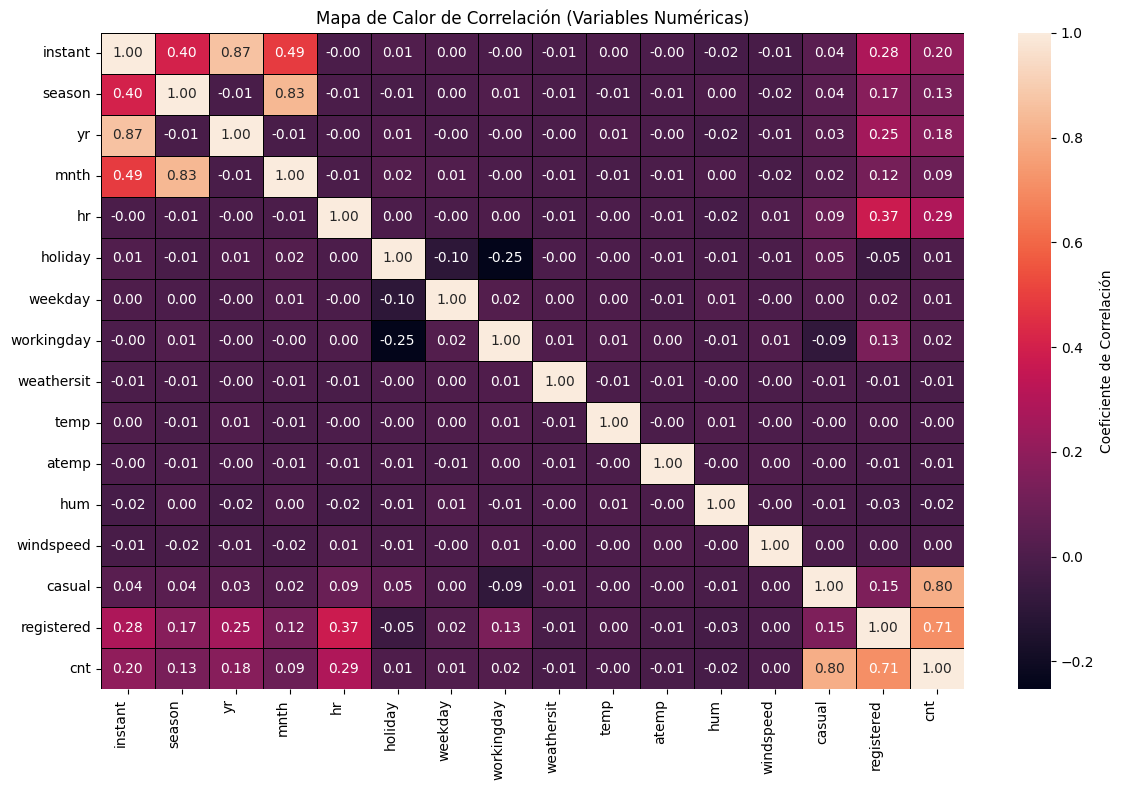

In [87]:
create_correlation_heatmap(bike_sharing_df, num_cols)

C:\Users\landy\AppData\Local\Temp\ipykernel_20364\4152536430.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


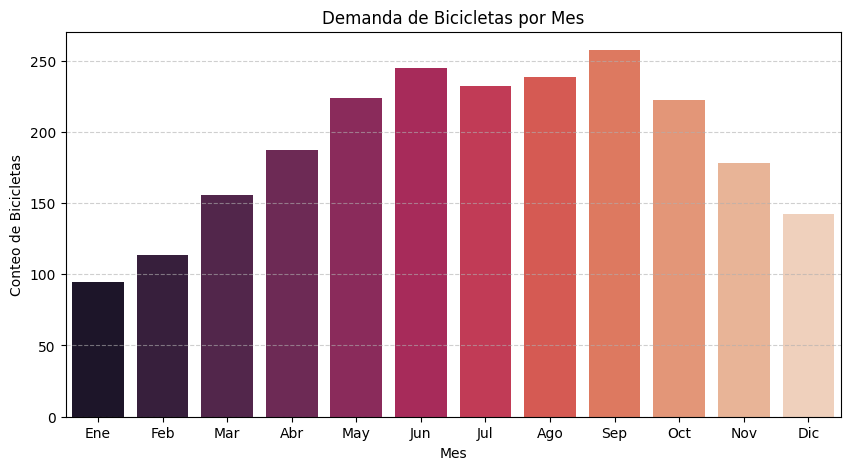

In [88]:
plt.figure(figsize=(10, 5))

sns.barplot(
    x='mnth', 
    y='cnt',
    data=bike_sharing_df, 
    palette='rocket',
    errorbar=None 
)

month_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
plt.xticks(ticks=range(12), labels=month_labels)
plt.title('Demanda de Bicicletas por Mes', fontsize=12)
plt.xlabel('Mes')
plt.ylabel('Conteo de Bicicletas')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

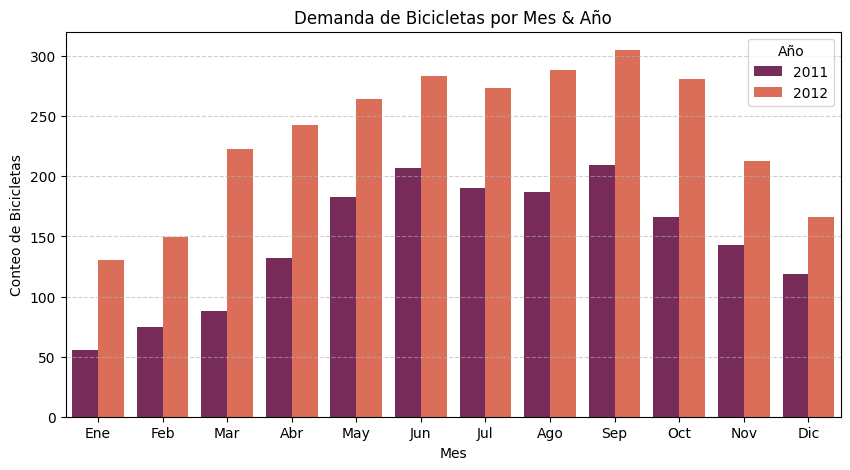

In [89]:
plt.figure(figsize=(10, 5))

sns.barplot(
    x='mnth', 
    y='cnt', 
    hue='yr',
    data=bike_sharing_df, 
    palette='rocket',
    errorbar=None 
)

month_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
plt.xticks(ticks=range(12), labels=month_labels)
plt.legend(title='Año', labels=['2011', '2012'])
plt.title('Demanda de Bicicletas por Mes & Año', fontsize=12)
plt.xlabel('Mes')
plt.ylabel('Conteo de Bicicletas')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

C:\Users\landy\AppData\Local\Temp\ipykernel_20364\1561675215.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


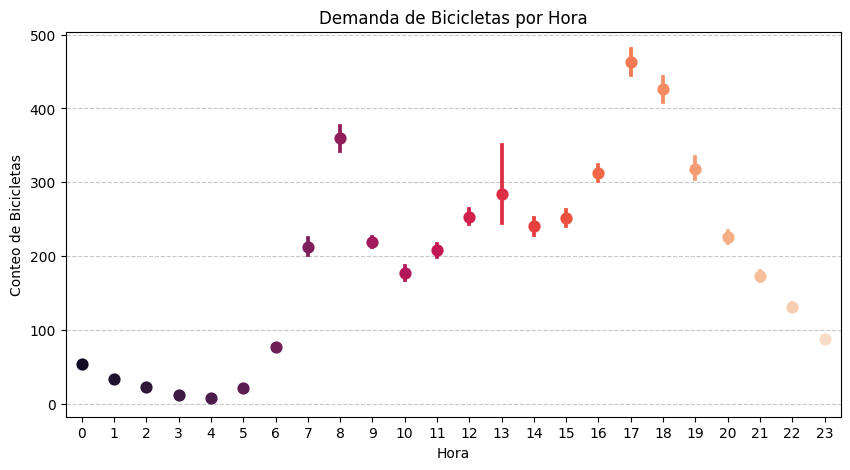

In [90]:
plt.figure(figsize=(10, 5))

sns.pointplot(
    x='hr', 
    y='cnt',
    data=bike_sharing_df, 
    errorbar=('ci', 95),
    palette='rocket'
)

plt.title('Demanda de Bicicletas por Hora')
plt.xlabel('Hora')
plt.ylabel('Conteo de Bicicletas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

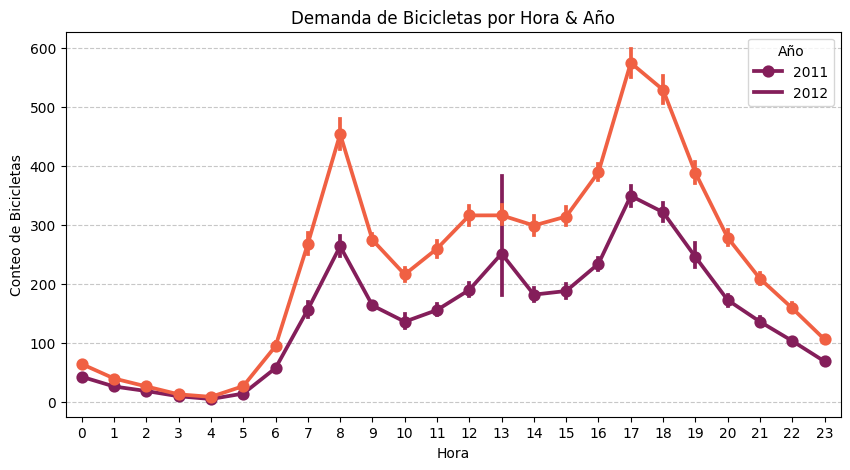

In [91]:
plt.figure(figsize=(10, 5))

sns.pointplot(
    x='hr', 
    y='cnt', 
    hue='yr',
    data=bike_sharing_df, 
    errorbar=('ci', 95),
    palette='rocket'
)

plt.legend(title='Año', labels=['2011', '2012'])
plt.title('Demanda de Bicicletas por Hora & Año', fontsize=12)
plt.xlabel('Hora')
plt.ylabel('Conteo de Bicicletas')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

C:\Users\landy\AppData\Local\Temp\ipykernel_20364\1825908768.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


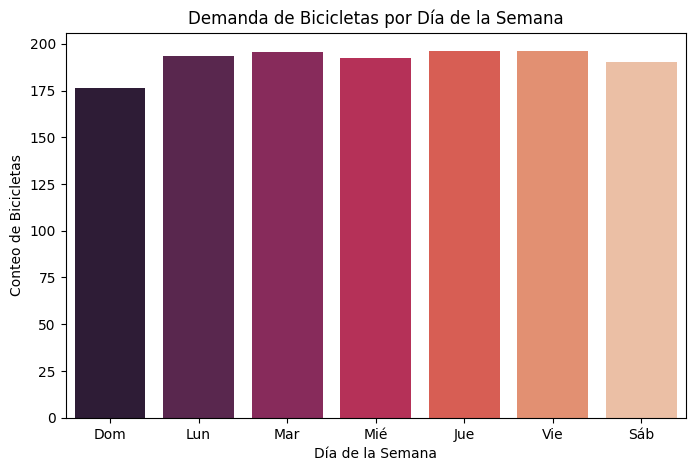

In [92]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x='weekday', 
    y='cnt', 
    data=bike_sharing_df, 
    palette='rocket', 
    errorbar=None
)

weekday_labels = ['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb']
plt.xticks(ticks=range(7), labels=weekday_labels, rotation=0)
plt.title('Demanda de Bicicletas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Conteo de Bicicletas')

plt.show()

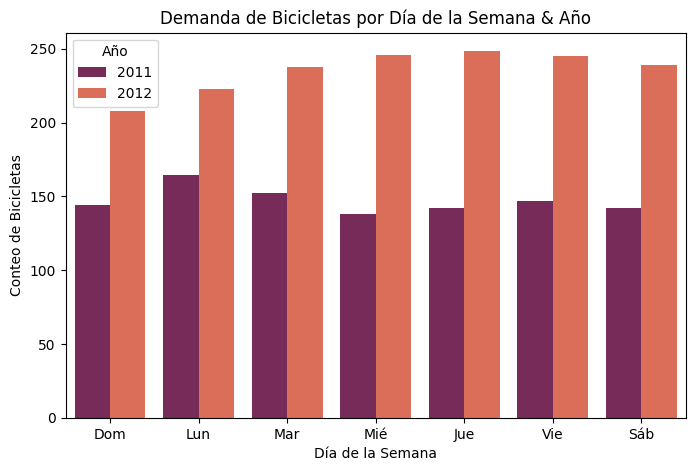

In [93]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x='weekday', 
    y='cnt', 
    hue='yr',
    data=bike_sharing_df, 
    palette='rocket', 
    errorbar=None
)

weekday_labels = ['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb']
plt.xticks(ticks=range(7), labels=weekday_labels, rotation=0)
plt.legend(title='Año', labels=['2011', '2012'])
plt.title('Demanda de Bicicletas por Día de la Semana & Año')
plt.xlabel('Día de la Semana')
plt.ylabel('Conteo de Bicicletas')

plt.show()

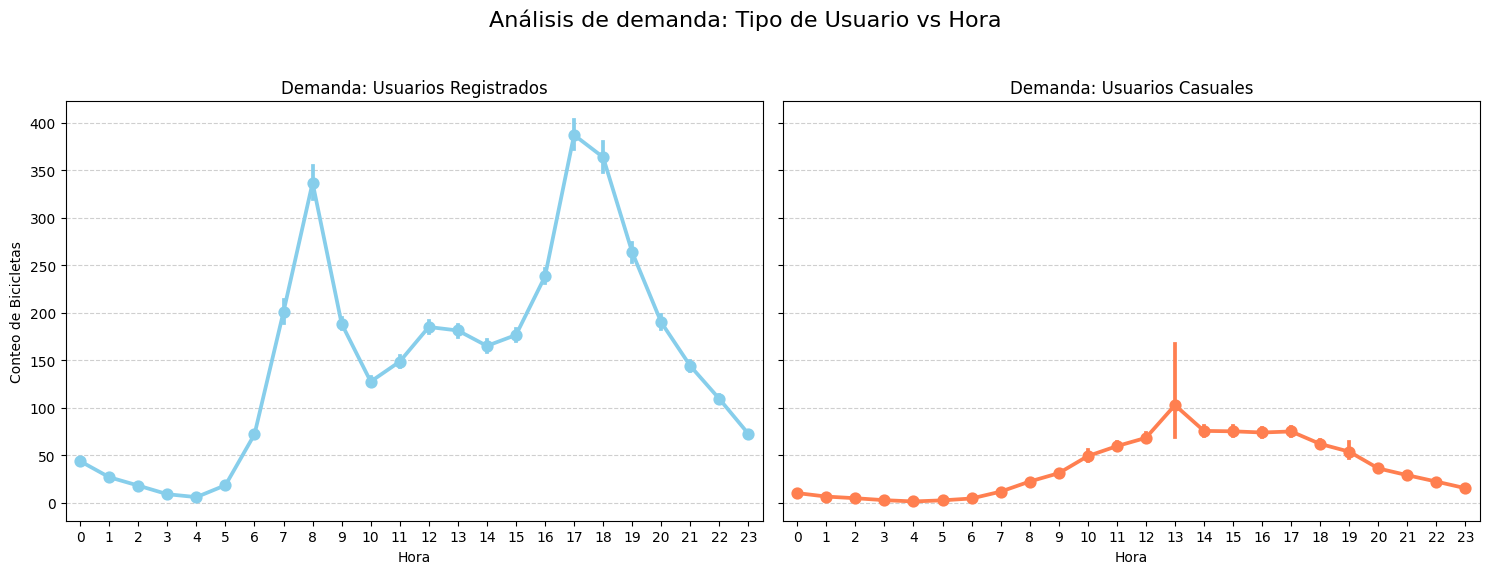

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.pointplot(x='hr', y='registered', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[0], color='skyblue')
ax[0].set_title('Demanda: Usuarios Registrados')
ax[0].set_xlabel('Hora')
ax[0].set_ylabel('Conteo de Bicicletas')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

sns.pointplot(x='hr', y='casual', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[1], color='coral')
ax[1].set_title('Demanda: Usuarios Casuales')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Conteo de Bicicletas')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Análisis de demanda: Tipo de Usuario vs Hora', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

C:\Users\landy\AppData\Local\Temp\ipykernel_20364\900532733.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.pointplot(x='hr', y='registered', hue='yr', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[0], color='skyblue')
C:\Users\landy\AppData\Local\Temp\ipykernel_20364\900532733.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:coral'` for the same effect.

  sns.pointplot(x='hr', y='casual', hue='yr', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[1], color='coral')


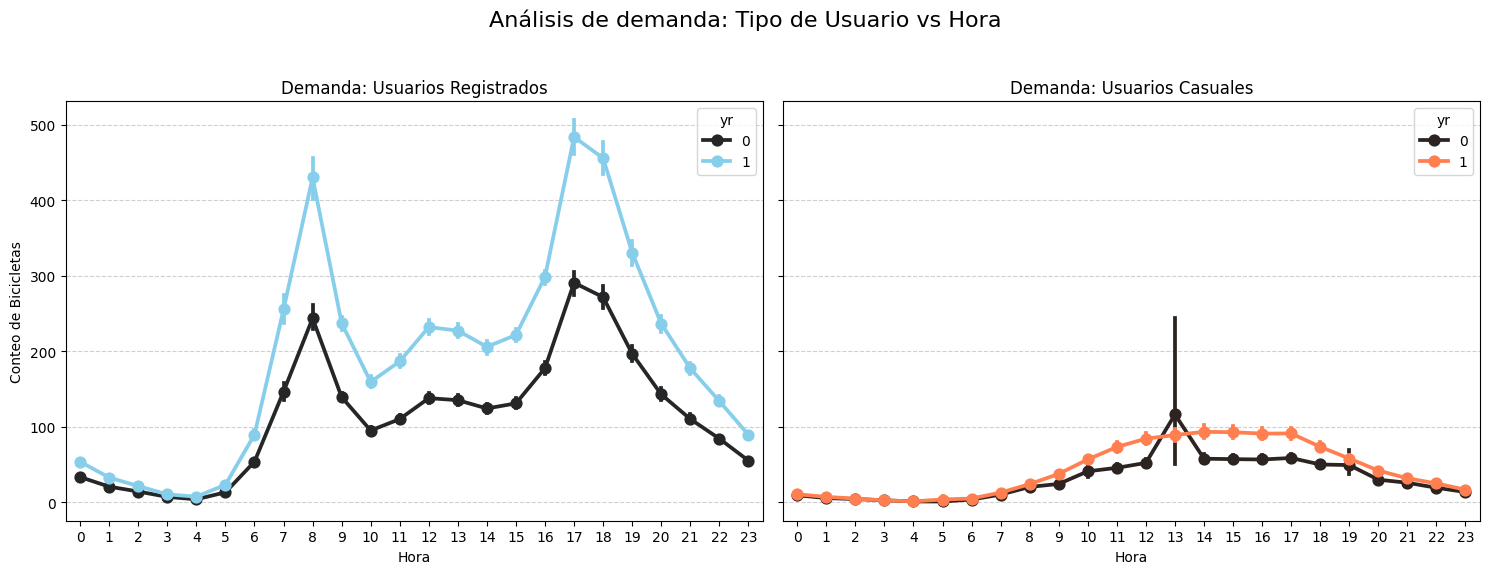

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.pointplot(x='hr', y='registered', hue='yr', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[0], color='skyblue')
ax[0].set_title('Demanda: Usuarios Registrados')
ax[0].set_xlabel('Hora')
ax[0].set_ylabel('Conteo de Bicicletas')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

sns.pointplot(x='hr', y='casual', hue='yr', data=bike_sharing_df, errorbar=('ci', 95), ax=ax[1], color='coral')
ax[1].set_title('Demanda: Usuarios Casuales')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Conteo de Bicicletas')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Análisis de demanda: Tipo de Usuario vs Hora', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

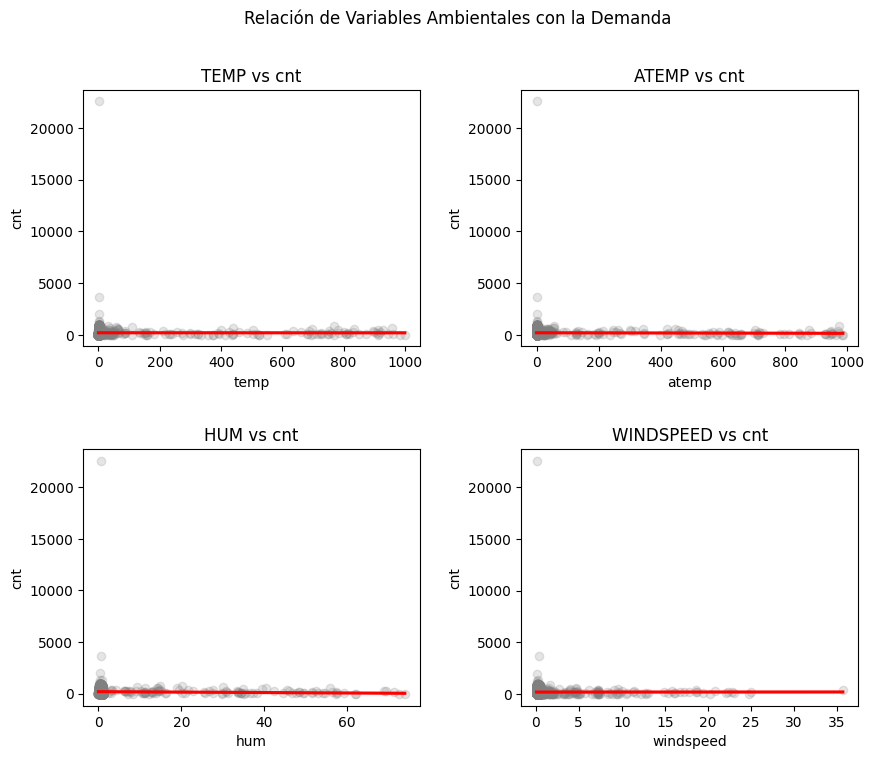

In [96]:
key_variable = 'cnt'
environmental_cols = ['temp', 'atemp', 'hum', 'windspeed']

plot_cols = environmental_cols  

n_cols = 2
n_rows = (len(plot_cols) + n_cols - 1) // n_cols 

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
fig.suptitle(f'Relación de Variables Ambientales con la Demanda', fontsize=12)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

axes = axs.ravel()

for i, column in enumerate(plot_cols):
    
    sns.regplot(
        x=bike_sharing_df[column], 
        y=bike_sharing_df[key_variable], 
        ax=axes[i], 
        scatter_kws={'alpha': 0.2, 'color': 'gray'}, 
        line_kws={'color': 'red'}                    
    )
    axes[i].set_title(f'{column.upper()} vs {key_variable}', fontsize=12)

for j in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[j])

plt.show()

# Notas:
- Septiembre es el mes con mayor demanda
- La demanda incremento considerablemente de 2011 a 2012
- En general todos los patrones se mantienen de un año a otro, excepto por los días de la semana: los lunes había una demanda mayor en 2011, es muy observable esta diferencia dado que en 2012 se regularizó la demanda en todos los días. En 2011 es muy notorio que únicamente los lunes había un pico de renta de bicicletas
- La demanda promedio de bicicletas aumenta con base en el horario laboral. Los principales picos están a la hora de entrada y salida de oficina estándar: 8 am, 4-6 pm. Asimismo se observa un pico en la demanda a la hora de la comida: 1 pm
- Parece haber un ligero incremento en la demanda los días Jueves y Viernes, sin embargo todos los días mantienen la demanda promedio
- El único día con una ligera demanda menor son los domingos
- La mayoría de los usuarios son registrados
- La demanda de usuarios casuales incrementa a la 1 pm, parece ser por la hora de comida estándar
- Variables ambientales: si bien la demanda parece ser un poco más alta cuando las condiciones climáticas son apropiadas (variables con parámetros bajos), no parece existir una correlación alta

# Ingeniería de Características:

In [97]:
def log_transform(df, log_cols):
    for col in log_cols:
        df[f'{col}_log'] = np.log1p(df[col])

    return df

In [98]:
def cyclic_transform(df, cyclic_cols):
    for col in cyclic_cols:
        if col == 'hr':
            period = 24
        elif col == 'mnth':
            period = 12
        elif col == 'weekday':
            period = 7
        else:
            continue

        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)

    df.drop(columns=cyclic_cols, inplace=True)

    return df

In [99]:
def ohe_transform(df, cat_cols):
    df = pd.get_dummies(
        df, 
        columns=cat_cols, 
        drop_first=True,
        dtype=int
    )

    return df

In [100]:
log_transform_cols = ['cnt', 'casual', 'registered', 'temp', 'atemp', 'hum', 'windspeed'] # columnas con alto sesgo
cyclic_cols = ['mnth', 'hr', 'weekday']
categorical_cols = ['season', 'yr', 'weathersit', 'holiday', 'workingday']

bike_sharing_df = log_transform(bike_sharing_df, log_transform_cols)
bike_sharing_df = cyclic_transform(bike_sharing_df, cyclic_cols)
bike_sharing_df = ohe_transform(bike_sharing_df, categorical_cols)

# Modelo (Regresión):

In [ ]:
X = bike_sharing_df.drop(columns=['cnt', 'casual', 'registered', 'cnt_log', 'casual_log', 'registered_log', 'dteday'])
y = bike_sharing_df['cnt_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

cyclic_cols_to_scale = [col for col in X_train.columns if ('sin' in col) or ('cos' in col)]

X_train[cyclic_cols_to_scale] = scaler.fit_transform(X_train[cyclic_cols_to_scale])
X_test[cyclic_cols_to_scale] = scaler.transform(X_test[cyclic_cols_to_scale])

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_log_rf = rf_model.predict(X_test)

y_pred_original_rf = np.expm1(y_pred_log_rf)
y_test_original = np.expm1(y_test)

y_pred_original_rf[y_pred_original_rf < 0] = 0 

r2 = r2_score(y_test_original, y_pred_original_rf)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original_rf))
mae = mean_absolute_error(y_test_original, y_pred_original_rf)

print(f'Random Forest Regressor')
print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original_rf)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', linestyle='--')
plt.title('Random Forest: Valores Reales vs. Predichos')
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.show()